In [35]:
#colab.research.google.com
#https://www.youtube.com/watch?v=9fjs8FeLMJk
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Program attempts to optimize users portfolio using Efficient Frontier

In [36]:
#get stock tickers in portfolio: FAANG
assets = ['FB','AMZN','AAPL','NFLX','GOOG']
assets

['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']

In [37]:
#assign weights, must equal 1
weight = 1/len(assets)
weights = np.array([weight,weight,weight,weight,weight])
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [38]:
#get portfolio start date, end date
stockStartDate = '2013-01-01'
stockEndDate = datetime.today().strftime('%Y-%m-%d')
stockStartDate,stockEndDate

('2013-01-01', '2020-05-11')

In [39]:
#create df to store adj close
df = pd.DataFrame()
for stock in assets:
    df[stock] = web.DataReader(stock,data_source='yahoo', start = stockStartDate, end = stockEndDate)['Adj Close']
df.head()

,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2013-01-02,28.000000,257.309998,68.502106,13.144286,360.274597
2013-01-03,27.770000,258.480011,67.637436,13.798572,360.483826
2013-01-04,28.760000,259.149994,65.753418,13.711429,367.607117
2013-01-07,29.420000,268.459991,65.366646,14.171429,366.003143
2013-01-08,29.059999,266.380005,65.542587,13.880000,365.280823


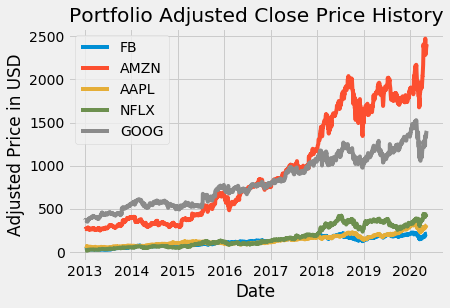

In [41]:
#show portfolio
title = 'Portfolio Adjusted Close Price History'

my_stocks = df
for stock in my_stocks.columns.values:
    plt.plot(my_stocks[stock],label = stock)
plt.title(title)
plt.xlabel('Date')
plt.ylabel('Adjusted Price in USD')
plt.legend(my_stocks.columns.values,loc='upper left')

plt.show()

In [45]:
#show daily returns
returns = df.pct_change()
daily_returns =returns[1:]

In [50]:
#covariance matrix
cov_matrix_annual = returns.cov()*252
cov_matrix_annual
#diaganol is the variance; square root of this is volatility
#rest is covariance

,FB,AMZN,AAPL,NFLX,GOOG
FB,0.115982,0.051870,0.040524,0.054121,0.048422
AMZN,0.051870,0.092108,0.035553,0.061191,0.046589
AAPL,0.040524,0.035553,0.076638,0.031818,0.037227
NFLX,0.054121,0.061191,0.031818,0.214138,0.048870
GOOG,0.048422,0.046589,0.037227,0.048870,0.064973


In [55]:
#portfolio variance
port_var = np.dot(weights.T,np.dot(cov_matrix_annual,weights))
print(port_var)

#portfolio volatility aka std dev
port_stdev = np.sqrt(port_var)
print(port_stdev)

#annual portfolio return
port_annual_returns = np.sum(returns.mean()*weights)*252
print(port_annual_returns)

0.05904841745615082
0.24299880134714824
0.3459141948281636


In [60]:
#expected var, vol, return
percent_var = str(round(port_var*100,2))+'%'
percent_vol = str(round(port_stdev*100,2))+'%'
percent_return = str(round(port_annual_returns*100,2))+'%'
print('Expected Variance: ' + percent_var)
print('Expected Volatility: ' + percent_vol)
print('Expected Annual Returns: ' + percent_return)

Expected Variance: 5.9%
Expected Volatility: 24.3%
Expected Annual Returns: 34.59%


In [61]:
pip install PyPortfolioOpt

     |████████████████████████████████| 49 kB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 10.2 MB 7.6 MB/s eta 0:00:01    |████████████████████████████▌   | 9.0 MB 7.6 MB/s eta 0:00:01     |█████████████████████████████   | 9.2 MB 7.6 MB/s eta 0:00:01
     |████████████████████████████████| 746 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 126 kB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 5.9 MB/s eta 0:00:01
     |███████████████████████████████ | 153 kB 2.8 MB/s eta 0:00:01     |████████████████████████████████| 158 kB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 4.2 MB/s eta 0:00:01     |████████████████▍               | 1.8 MB 4.2 MB/s eta 0:00:01     |███████████████████████████████▏| 3.5 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 151 kB 7.7 MB/s eta 0:00:01
  Created wheel for ecos: filename=ecos-2.0.7.post1-cp37-cp37m-macosx_10_9_x86_64.whl size=84486 sha256=0c9cb719fab0d26ae417a5495b6

In [62]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [73]:
#portfolio optimization
#expected returns and annualized sample covariance matrix of asset returns 
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

#optimize for max sharpe ratio: returns/vol
ef = EfficientFrontier(mu,S)
weights = ef.max_sharpe()
cleaned_weights=ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose=True)

{'FB': 0.15414, 'AMZN': 0.28938, 'AAPL': 0.20507, 'NFLX': 0.35141, 'GOOG': 0.0}
Expected annual return: 40.8%
Annual volatility: 27.3%
Sharpe Ratio: 1.42


(0.40779136895328333, 0.2728341560438953, 1.4213446533831084)

In [79]:
#get discrete allocation for each share of stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
da = DiscreteAllocation(weights,latest_prices,total_portfolio_value=100000)

allocation,leftover = da.lp_portfolio()
print('Discrete Allocation:'+ str(allocation))
print('Funds Remaining: ${:.2f}'.format(leftover))

Discrete Allocation:{'FB': 72.0, 'AMZN': 12.0, 'AAPL': 65.0, 'NFLX': 80.0}
Funds Remaining: $25.79
